In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from glob import glob
import re
from pathlib import Path
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator

2024-04-23 15:25:07.264562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 15:25:07.900986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:

def read_data(train_event_files):

    pattern = r"ITM_Classifier(?:_Advanced)?_(vanilla_vit|[a-z]+)_([a-z_]+)_trainable_(True|False)_epochs_(\d+)-(\d+)"
    data = []
    for fn in train_event_files:
        nm = fn.split("/")[2]

        matches = re.match(pattern, nm)

        experiment = {
            "image_encoder": matches.groups()[0],
            "text_encoder": matches.groups()[1],
            "trainable": matches.groups()[2] == "True",
            "epochs": int(matches.groups()[3]),
            "timestamp": int(matches.groups()[4]),
        }

        for val_type, fn in zip(
            ["train", "validation"], [fn, fn.replace("train/", "validation/")]
        ):
            experiment[val_type] = {"epoch_losses": [], "epoch_binary_accuracies": []}

            fn = str(list(Path(fn).parent.glob("events*"))[0])

            for summary in summary_iterator(fn):
                for value in summary.summary.value:
                    if value.tag == "epoch_loss":
                        experiment[val_type]["epoch_losses"].append(
                            float(tf.make_ndarray(value.tensor))
                        )
                    if value.tag == "epoch_binary_accuracy":
                        experiment[val_type]["epoch_binary_accuracies"].append(
                            float(tf.make_ndarray(value.tensor))
                        )

        data.append(experiment)
    return data


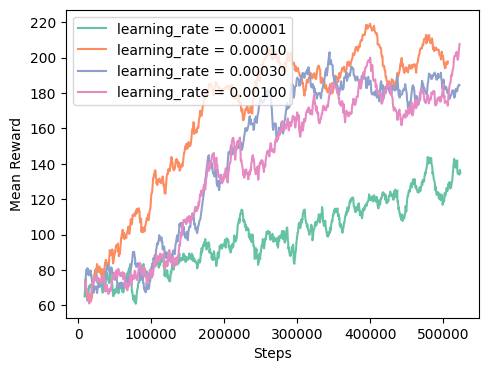

In [4]:
import json
from io import StringIO


def folders_and_params(filters={}):
    folders = []
    folder_params = []
    log_dir = Path("logs")
    for folder in log_dir.glob("*"):
        if (folder / "run_1").is_dir() and (folder / "output.mp4").is_file():
            with open(folder / "params.json") as fd:
                params = json.load(fd)

                should_add = True
                for k, v in filters.items():
                    if params[k] != v:
                        should_add = False

                if should_add:
                    folders.append(folder)
                    folder_params.append(params)

    ret = list(zip(folders, folder_params))
    ret.sort(key=lambda x: x[0])

    return ret


def read_data(f):
    train_event_file = Path(list(f.glob("run_1/events*"))[0])

    mean_rewards = []
    steps = []
    for summary in summary_iterator(str(train_event_file)):
        step = summary.step
        for value in summary.summary.value:
            if value.tag == "rollout/ep_rew_mean":
                mean_rewards.append(value.simple_value)
                steps.append(step)

    return mean_rewards, steps

def read_monitor_data(f):
    monitor_folder = f / "monitor"
    monitor_files = list(monitor_folder.glob("*.csv"))
    merged_monitor_data = ""
    for monitor_file in monitor_files:
        with open(monitor_file, "r") as fd:
            cmt = fd.readline()
            hdr = fd.readline()
            if merged_monitor_data == "":
                merged_monitor_data += cmt
                merged_monitor_data += hdr
            merged_monitor_data += fd.read()

    df = pd.read_csv(StringIO(merged_monitor_data), skiprows=1)
    df = df.sort_values("t")

    df["steps"] = df["l"].cumsum()

    mean_rewards = df["r"].rolling(100).mean().to_list()
    steps = df["steps"].tolist()

    return mean_rewards, steps

figsize = np.array([6.4, 4.8]) / 1.2
def plot_learning_curve(folders_and_params, labels):
    plt.figure(figsize=figsize)
    colors = sns.color_palette("Set2", len(folders_and_params))
    for (f, p), l, c in zip(folders_and_params, labels, colors):
        mean_rewards, steps = read_monitor_data(f)

        if len(steps) > 16:
            steps = steps[2::4]
            mean_rewards = mean_rewards[2::4]

        plt.plot(
            steps, mean_rewards, label=l, color=c,
        )

    plt.legend()
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")

fnp = [
    (f, p)
    for f, p in folders_and_params(
        {
            "num_training_steps": 500000,
            "learningAlg": "PPO",
            "gamma": 0.9,
            "exploration_fraction": 0.9,
        }
    )
    if "2024-04-20" in str(f)
]
fnp.sort(key=lambda x: x[1]["learning_rate"])
labels = [
    f"learning_rate = {p['learning_rate']:0.5f}"
    for f, p in fnp
]
plot_learning_curve(fnp, labels)

plt.savefig("../report/figures/compare_learning_rate.png")

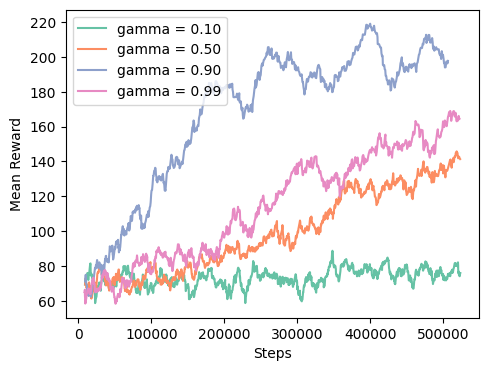

In [5]:
fnp = [
    (f, p)
    for f, p in folders_and_params(
        {
            "num_training_steps": 500000,
            "learningAlg": "PPO",
            "learning_rate": 0.0001,
            "exploration_fraction": 0.9,
        }
    )
    if "2024-04-20" in str(f)
]
fnp.sort(key=lambda x: x[1]["gamma"])
labels = [
    f"gamma = {p['gamma']:0.2f}"
    for f, p in fnp
]
plot_learning_curve(fnp, labels)

# plt.savefig("../report/figures/compare_gamma.png")

<function <lambda> at 0x73791eae17e0>


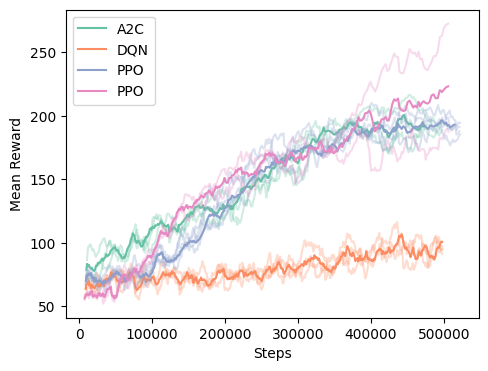

In [6]:
def plot_average_learning_curve(folders_and_params, labels):
    plt.figure(figsize=figsize)
    params = [p for f, p in folders_and_params]
    for i in range(len(params)):
        params[i]["seed"] = 0

    params_set = []
    for p in params:
        if p not in params_set:
            params_set.append(p)

    colors = sns.color_palette("Set2", len(params_set))
    # colors = sns.color_palette()

    for i, p_group in enumerate(params_set):
        group_steps = []
        group_mean_rewards = []

        good_p = {}
        for f, p in folders_and_params:
            p["seed"] = 0
            if p_group == p:
                good_p = p
                mean_rewards, steps = read_monitor_data(f)
                mean_rewards = mean_rewards[::10]
                steps = steps[::10]

                group_steps.append(steps)
                group_mean_rewards.append(mean_rewards)

                plt.plot(
                    steps, mean_rewards,
                    color = colors[i], alpha=0.3
                )

        group_lens = [len(g) for g in group_steps]
        min_len = min(group_lens)

        average_mean_rewards = np.mean(
            [g[:min_len] for g in group_mean_rewards], axis=0
        )

        plt.plot(
            group_steps[0][:min_len], average_mean_rewards, label=labels(f, good_p),
            color = colors[i]
        )

    plt.legend()
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")

fnp = [
    (f, p)
    for f, p in folders_and_params(
        {
            "num_training_steps": 500000,
            "learning_rate": 0.0003,
            "gamma": 0.9,
            "exploration_fraction": 0.9,
        }
    )
]
fnp.sort(key=lambda x: x[1]["learningAlg"])
labels = lambda f, p: f"{p['learningAlg']}"

print(labels)
plot_average_learning_curve(fnp, labels)

plt.savefig("../report/figures/compare_alg.png")

<function <lambda> at 0x7379dbef5900>
[(PosixPath('logs/2024-04-22_00-43-41'), {'environmentID': 'SuperMarioBros2-v1', 'trainMode': True, 'learningAlg': 'PPO', 'num_training_steps': 5000000, 'num_test_episodes': 10, 'learning_rate': 0.0001, 'gamma': 0.9, 'policy_rendering': True, 'replay_buffer_size': 30000, 'exploration_fraction': 0.9, 'seed': 0})]


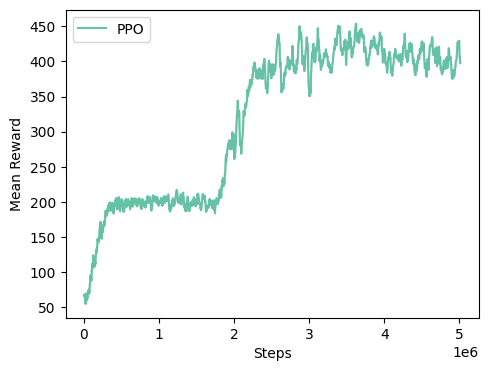

In [7]:
fnp = [
    (f, p)
    for f, p in folders_and_params(
        {
            "learningAlg": "PPO",
            "num_training_steps": 5000000,
            "learning_rate": 0.0001,
            "gamma": 0.9,
            "exploration_fraction": 0.9,
        }
    )
]

labels = lambda f, p: f"{p['learningAlg']}"

print(labels)
plot_average_learning_curve(fnp, labels)

plt.savefig("../report/figures/final_training.png")
print(fnp)

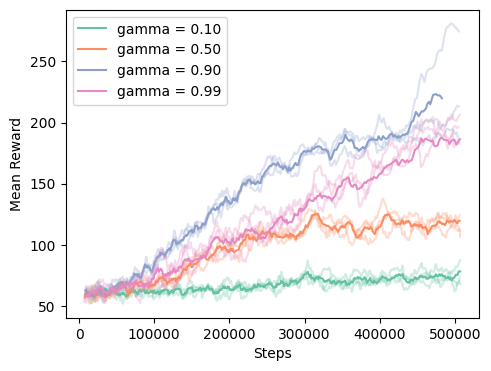

In [8]:
fnp = [
    (f, p)
    for f, p in folders_and_params(
        {
            "num_training_steps": 500000,
            "learningAlg": "PPO",
            "learning_rate": 0.0001,
            "exploration_fraction": 0.9,
        }
    )
    if "2024-04-22" in str(f) or "2024-04-23" in str(f)
]
fnp.sort(key=lambda x: x[1]["gamma"])
labels = lambda f, p: f"gamma = {p['gamma']:0.2f}"

plot_average_learning_curve(fnp, labels)
plt.savefig("../report/figures/compare_gamma.png")


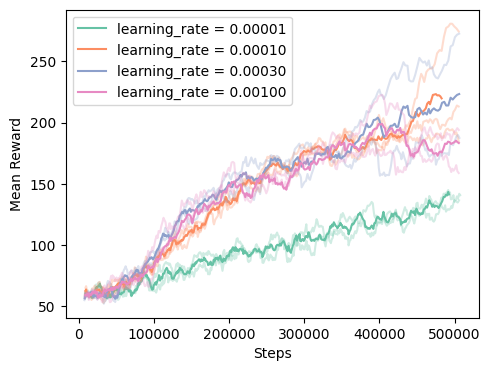

In [10]:
fnp = [
    (f, p)
    for f, p in folders_and_params(
        {
            "num_training_steps": 500000,
            "learningAlg": "PPO",
            "gamma": 0.9,
            "exploration_fraction": 0.9,
        }
    )
    if "2024-04-22" in str(f) or "2024-04-23" in str(f)
]
fnp.sort(key=lambda x: x[1]["learning_rate"])
labels = lambda f, p: f"learning_rate = {p['learning_rate']:0.5f}"

plot_average_learning_curve(fnp, labels)
plt.savefig("../report/figures/compare_learning_rate.png")